In [10]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D , Dropout , Dense , Flatten
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

### Compile model

In [11]:
CLASSES = 4

In [12]:
base_model = VGG16(input_shape=(90, 120, 3),weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

### Load Images

In [13]:
path = "D:/test/dataset/"

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.5,
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validate_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [15]:
train_generator = train_datagen.flow_from_directory(path+'train/',
                                                  batch_size=10,
                                                    target_size=(90,120),
                                                  class_mode='categorical')

validation_generator = validate_datagen.flow_from_directory(path+'val/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_directory(path+'test/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

Found 424 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


### Train model (only the top layers)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 69s 1s/step - loss: 1.9305 - accuracy: 0.5457 - val_loss: 0.2798 - val_accuracy: 0.8833
Epoch 2/50
42/42 [==============================] - 65s 2s/step - loss: 0.4515 - accuracy: 0.8226 - val_loss: 0.7849 - val_accuracy: 0.7667
Epoch 3/50
42/42 [==============================] - 67s 2s/step - loss: 0.3565 - accuracy: 0.8947 - val_loss: 0.2683 - val_accuracy: 0.9250
Epoch 4/50
42/42 [==============================] - 62s 1s/step - loss: 0.2436 - accuracy: 0.9113 - val_loss: 0.2691 - val_accuracy: 0.9083
Epoch 5/50
42/42 [==============================] - 61s 1s/step - loss: 0.2919 - accuracy: 0.9219 - val_loss: 0.2634 - val_accuracy: 0.8917
Epoch 6/50
42/42 [==============================] - 60s 1s/step - loss: 0.2621 - accuracy: 0.9118 - val_loss: 0.3351 - val_accuracy: 0.9250
Epoch 7/50
42/42 [==============================] - 62s 1s/step - loss: 0.3148 - accuracy: 0.8993 - val_loss: 0.6494 - val_accuracy: 0.8167
Epoch 8/50
42/42 [==

### Train (fine-tune bottom 2 layers)

In [19]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 22s 399ms/step - loss: 0.9911 - accuracy: 0.6863 - val_loss: 0.3323 - val_accuracy: 0.9083
Epoch 2/50
42/42 [==============================] - 15s 363ms/step - loss: 0.6563 - accuracy: 0.7732 - val_loss: 0.3127 - val_accuracy: 0.8917
Epoch 3/50
42/42 [==============================] - 16s 382ms/step - loss: 0.5880 - accuracy: 0.8013 - val_loss: 0.3311 - val_accuracy: 0.8917
Epoch 4/50
42/42 [==============================] - 17s 406ms/step - loss: 0.3768 - accuracy: 0.8625 - val_loss: 0.3391 - val_accuracy: 0.8583
Epoch 5/50
42/42 [==============================] - 16s 388ms/step - loss: 0.5096 - accuracy: 0.8072 - val_loss: 0.3852 - val_accuracy: 0.8417
Epoch 6/50
42/42 [==============================] - 17s 404ms/step - loss: 0.4672 - accuracy: 0.8233 - val_loss: 0.3868 - val_accuracy: 0.8583
Epoch 7/50
42/42 [==============================] - 17s 401ms/step - loss: 0.4256 - accuracy: 0.8695 - val_loss: 0.3624 - val_accuracy: 0.9000

### Evaluate model & Visualize performance

In [17]:
model.evaluate(test_generator)

7/7 [==============================] - 4s 535ms/step - loss: 0.3473 - accuracy: 0.9219


[0.3472995162010193, 0.921875]

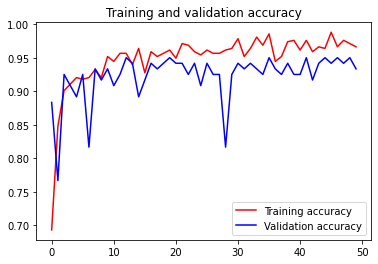

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
fig = plt.gcf()
fig.savefig('from_VGG16.png',dpi=fig.dpi)
plt.show()



### Save model

In [19]:
model.save('from_VGG16.h5')
model.save_weights('from_VGG16_weights.h5')